In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.graph_objects as go
import math

from plotly.subplots import make_subplots
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import  LabelEncoder ,StandardScaler, OneHotEncoder,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix , accuracy_score , recall_score , f1_score , classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.svm import SVC

warnings.filterwarnings('ignore')


In [54]:
dataset = pd.read_csv('US_Accidents_March23.csv',nrows=500000)

In [55]:
target = "Severity"


In [56]:
from sklearn.model_selection import train_test_split

_, dataset_sample = train_test_split(dataset, test_size=10000, stratify=dataset[target], random_state=42)

In [57]:
def print_distribution_of_target(dataset):
    target_counts = dataset[target].value_counts()
    total_samples = len(dataset)

    for value, count in target_counts.items():
        percentage = (count / total_samples) * 100
        print(f"{value}: {percentage:.2f}%")
        
print("dataset")
print_distribution_of_target(dataset)

print("dataset sample")
print_distribution_of_target(dataset_sample)

dataset
2: 62.43%
3: 37.43%
1: 0.08%
4: 0.06%
dataset sample
2: 62.43%
3: 37.43%
1: 0.08%
4: 0.06%


In [58]:
dataset_sample.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 269322 to 472645
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     10000 non-null  object 
 1   Source                 10000 non-null  object 
 2   Severity               10000 non-null  int64  
 3   Start_Time             10000 non-null  object 
 4   End_Time               10000 non-null  object 
 5   Start_Lat              10000 non-null  float64
 6   Start_Lng              10000 non-null  float64
 7   End_Lat                0 non-null      float64
 8   End_Lng                0 non-null      float64
 9   Distance(mi)           10000 non-null  float64
 10  Description            10000 non-null  object 
 11  Street                 10000 non-null  object 
 12  City                   10000 non-null  object 
 13  County                 10000 non-null  object 
 14  State                  10000 non-null  object 
 

In [59]:
object_cols = dataset_sample.select_dtypes(include=['object']).columns

dataset_sample[object_cols] = dataset_sample[object_cols].astype('category')

dataset_sample["Description"] = dataset_sample["Description"].astype('string')

datetime_feature_names = ["Start_Time", "End_Time", "Weather_Timestamp"]
for feature_name in datetime_feature_names:
    dataset_sample[feature_name] = pd.to_datetime(dataset_sample[feature_name], format='%Y-%m-%d %H:%M:%S', errors='coerce')

datetime_cols = dataset_sample.select_dtypes(include=['datetime64[ns]']).columns.tolist()
cat_cols = dataset_sample.select_dtypes(include=['category']).columns.tolist()
bool_cols = dataset_sample.select_dtypes(include=['bool']).columns.tolist()
num_cols = dataset_sample.select_dtypes(include=['float', 'int']).columns.tolist()
string_cols = dataset_sample.select_dtypes(include=['string']).columns.tolist()

In [60]:
dataset_sample.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 269322 to 472645
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     10000 non-null  category      
 1   Source                 10000 non-null  category      
 2   Severity               10000 non-null  int64         
 3   Start_Time             10000 non-null  datetime64[ns]
 4   End_Time               10000 non-null  datetime64[ns]
 5   Start_Lat              10000 non-null  float64       
 6   Start_Lng              10000 non-null  float64       
 7   End_Lat                0 non-null      float64       
 8   End_Lng                0 non-null      float64       
 9   Distance(mi)           10000 non-null  float64       
 10  Description            10000 non-null  string        
 11  Street                 10000 non-null  category      
 12  City                   10000 non-null  category      


In [61]:
pd.set_option('display.max_columns', None)
print(dataset_sample.head(10))

              ID   Source  Severity          Start_Time            End_Time  \
269322  A-269329  Source2         2 2017-01-10 11:05:07 2017-01-10 11:49:39   
183674  A-183681  Source2         3 2016-10-23 17:40:11 2016-10-23 18:09:45   
471110  A-471123  Source2         2 2017-06-07 10:35:20 2017-06-07 11:04:16   
492161  A-492174  Source2         2 2017-07-17 07:26:51 2017-07-17 08:11:29   
447768  A-447781  Source2         3 2017-05-23 07:26:11 2017-05-23 07:55:55   
417442  A-417455  Source2         2 2017-05-01 17:54:17 2017-05-01 18:39:07   
71360    A-71367  Source2         2 2016-11-11 19:37:31 2016-11-11 20:07:02   
347607  A-347617  Source2         3 2017-03-07 08:07:32 2017-03-07 08:44:00   
26713    A-26714  Source2         2 2016-08-10 23:59:50 2016-08-11 00:44:50   
489257  A-489270  Source2         2 2017-06-30 15:55:48 2017-06-30 16:40:32   

        Start_Lat   Start_Lng  End_Lat  End_Lng  Distance(mi)  \
269322  30.226599  -97.768661      NaN      NaN          0.01   


In [62]:
null_count = dataset_sample.isnull().sum()

total_rows = len(dataset_sample)
null_percentage = (null_count / total_rows) * 100

null_df = pd.DataFrame({'Null Count': null_count, 'Null Percentage': null_percentage})
print(null_df)

                       Null Count  Null Percentage
ID                              0             0.00
Source                          0             0.00
Severity                        0             0.00
Start_Time                      0             0.00
End_Time                        0             0.00
Start_Lat                       0             0.00
Start_Lng                       0             0.00
End_Lat                     10000           100.00
End_Lng                     10000           100.00
Distance(mi)                    0             0.00
Description                     0             0.00
Street                          0             0.00
City                            0             0.00
County                          0             0.00
State                           0             0.00
Zipcode                         1             0.01
Country                         0             0.00
Timezone                        1             0.01
Airport_Code                   

In [63]:
features_to_check = ["Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight"]
df_with_nulls = dataset_sample[dataset_sample['Sunrise_Sunset'].isnull()]
df_with_nulls[features_to_check].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Sunrise_Sunset         0 non-null      category
 1   Civil_Twilight         0 non-null      category
 2   Nautical_Twilight      0 non-null      category
 3   Astronomical_Twilight  0 non-null      category
dtypes: category(4)
memory usage: 496.0 bytes


In [64]:
features_to_check = ["End_Lat", "End_Lng"]
df_with_nulls = dataset_sample[dataset_sample['End_Lat'].isnull()]
df_with_nulls[features_to_check].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 269322 to 472645
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   End_Lat  0 non-null      float64
 1   End_Lng  0 non-null      float64
dtypes: float64(2)
memory usage: 234.4 KB


In [65]:
features_to_check = ["Start_Time", "End_Time"]
df_with_nulls = dataset_sample[dataset_sample['Start_Time'].isnull()]
df_with_nulls[features_to_check].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Start_Time  0 non-null      datetime64[ns]
 1   End_Time    0 non-null      datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 0.0 bytes


In [66]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_numeric_features(df, numeric_features):
    df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors='coerce')
    df[numeric_features].fillna(0)
    num_cols = len(numeric_features)
    fig, axs = plt.subplots(num_cols, 2, figsize=(12, num_cols*6))

    for i, feature in enumerate(numeric_features):
        # Histogram
        axs[i, 0].hist(df[feature], bins=20, color='skyblue', edgecolor='black')
        axs[i, 0].set_title(f'{feature} Histogram')
        axs[i, 0].set_xlabel(feature)
        axs[i, 0].set_ylabel('Frequency')

         # Boxplot
        axs[i, 1].boxplot(df[feature], vert=True)
        axs[i, 1].set_title(f'{feature} Boxplot')
        axs[i, 1].set_xlabel(feature)
        
    plt.tight_layout()
    plt.show()


In [67]:
def plot_boolean_features(df, bool_features):
    # Calculate the number of rows and columns for subplots
    num_features = len(bool_features)
    num_rows = num_features // 2 + num_features % 2
    num_cols = 2

    # Create subplots with rectangular shape
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 30))

    # Flatten the axes array to make it easier to iterate
    axes = axes.flatten()

    # Plot boolean counts for specified features
    for i, feature in enumerate(bool_features):
        counts = df[feature].value_counts()
        counts.plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'Boolean counts for {feature}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Count')

        # Hide empty subplots
    for j in range(num_features, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


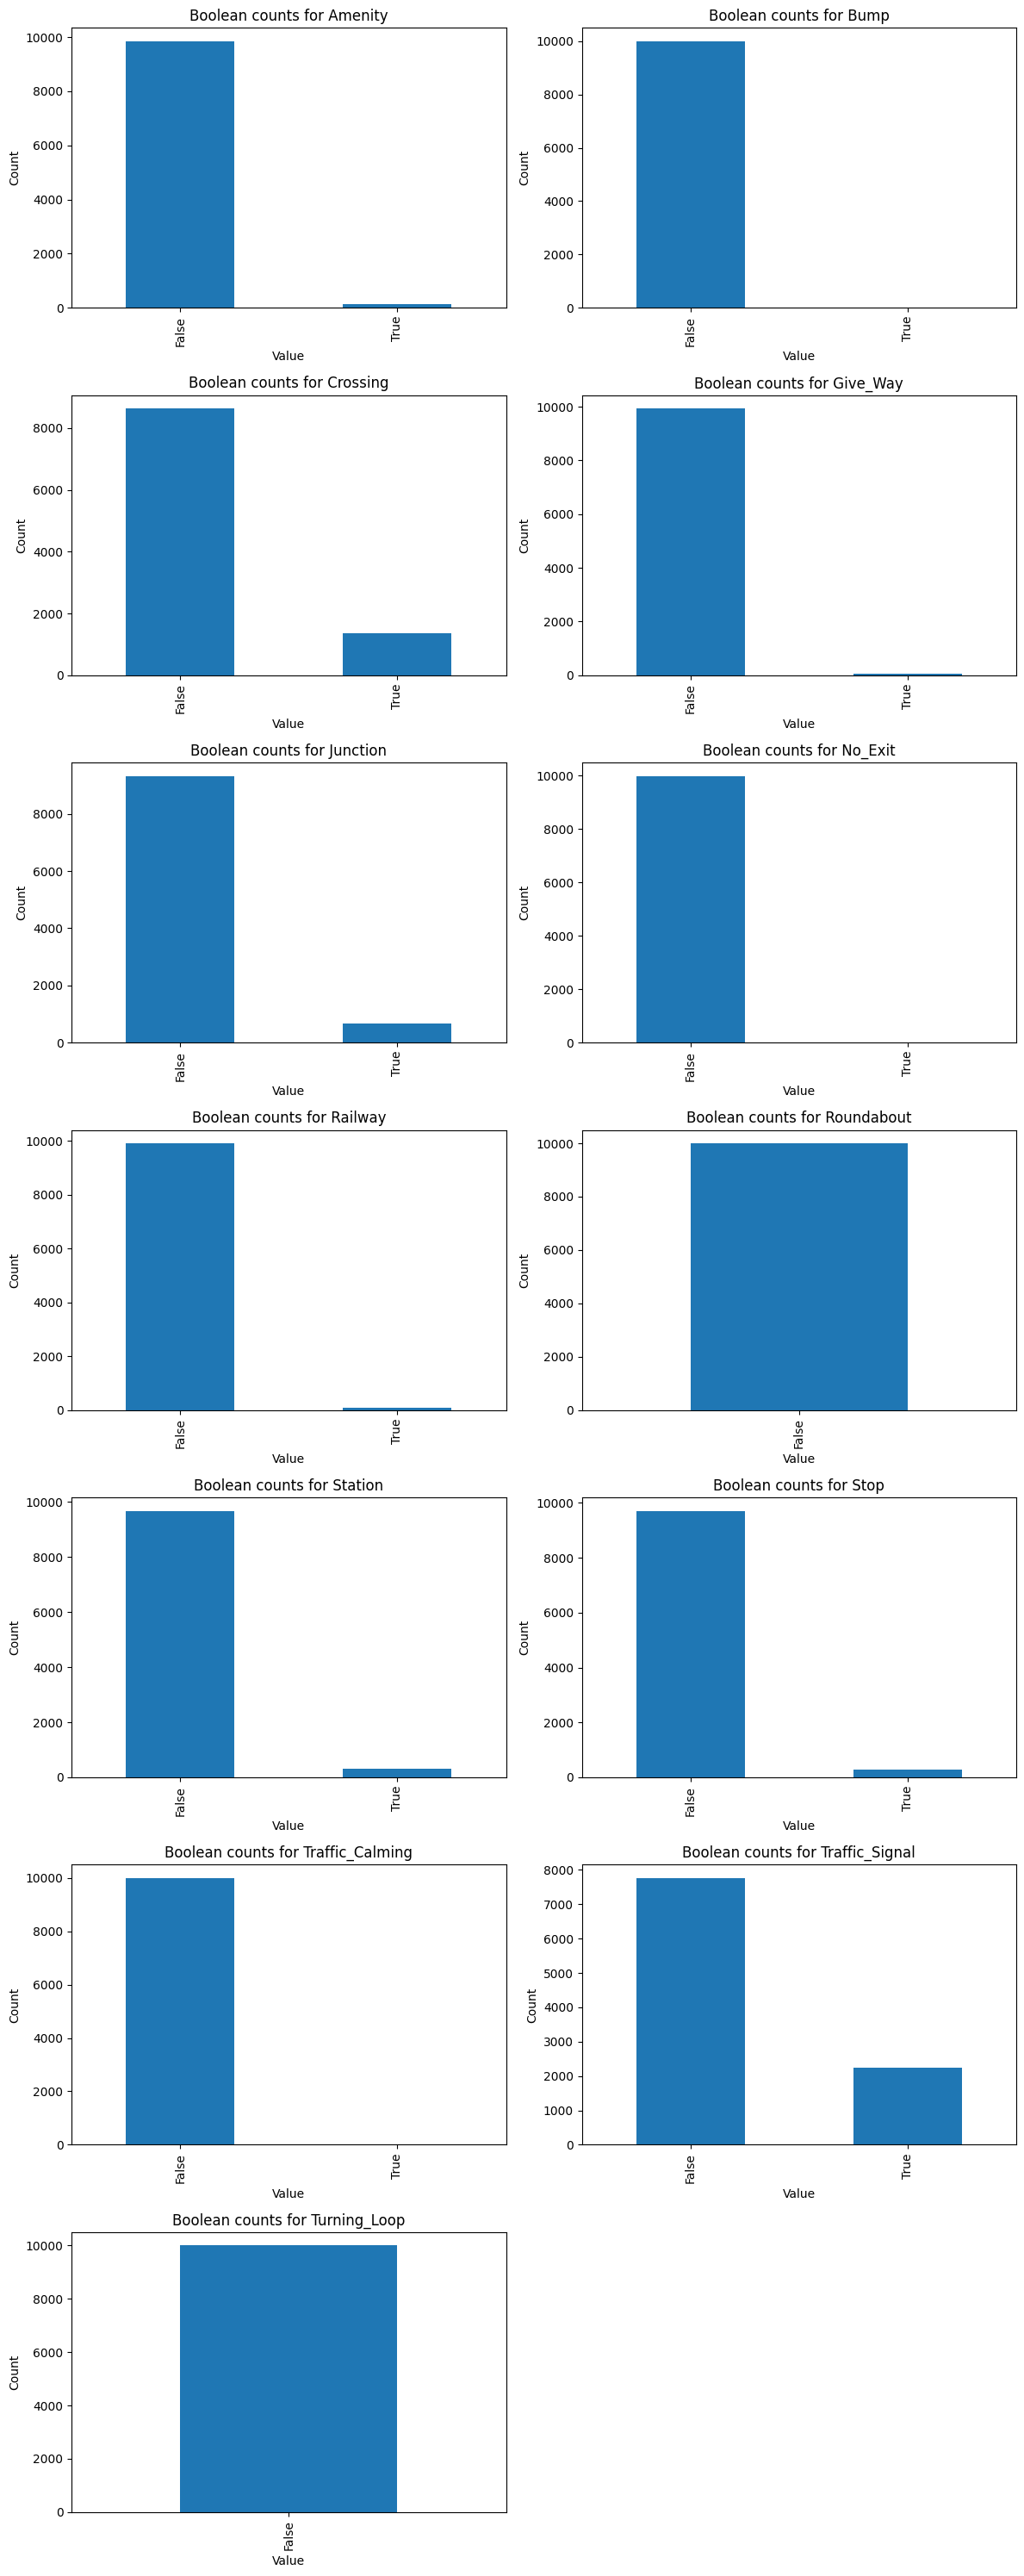

In [68]:
plot_boolean_features(dataset_sample, bool_cols)


In [69]:
for column in dataset_sample[bool_cols].columns:
    true_percentage = dataset_sample[column].mean() * 100
    false_percentage = 100 - true_percentage

    print(column)
    print(f"Percentage of True: {true_percentage:.2f}%")
    print(f"Percentage of False: {false_percentage:.2f}%")
    print()

Amenity
Percentage of True: 1.49%
Percentage of False: 98.51%

Bump
Percentage of True: 0.04%
Percentage of False: 99.96%

Crossing
Percentage of True: 13.67%
Percentage of False: 86.33%

Give_Way
Percentage of True: 0.70%
Percentage of False: 99.30%

Junction
Percentage of True: 6.71%
Percentage of False: 93.29%

No_Exit
Percentage of True: 0.16%
Percentage of False: 99.84%

Railway
Percentage of True: 0.91%
Percentage of False: 99.09%

Roundabout
Percentage of True: 0.00%
Percentage of False: 100.00%

Station
Percentage of True: 3.23%
Percentage of False: 96.77%

Stop
Percentage of True: 2.89%
Percentage of False: 97.11%

Traffic_Calming
Percentage of True: 0.08%
Percentage of False: 99.92%

Traffic_Signal
Percentage of True: 22.40%
Percentage of False: 77.60%

Turning_Loop
Percentage of True: 0.00%
Percentage of False: 100.00%



In [70]:
def plot_top_categories(df, cat_features):
    # Calculate the number of rows and columns for subplots
    num_features = len(df[cat_features].columns)
    num_rows = num_features // 2 + num_features % 2
    num_cols = 2

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 50))

    # Flatten the axes array to make it easier to iterate
    axes = axes.flatten()

    # Plot top categories for each categorical feature
    for i, column in enumerate(df[cat_features].columns):
        top_categories = df[column].value_counts().nlargest(50)
        top_categories.plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'Top categories for {column}')
        axes[i].set_xlabel('Category')
        axes[i].set_ylabel('Count')

          # Hide empty subplots
    for j in range(num_features, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

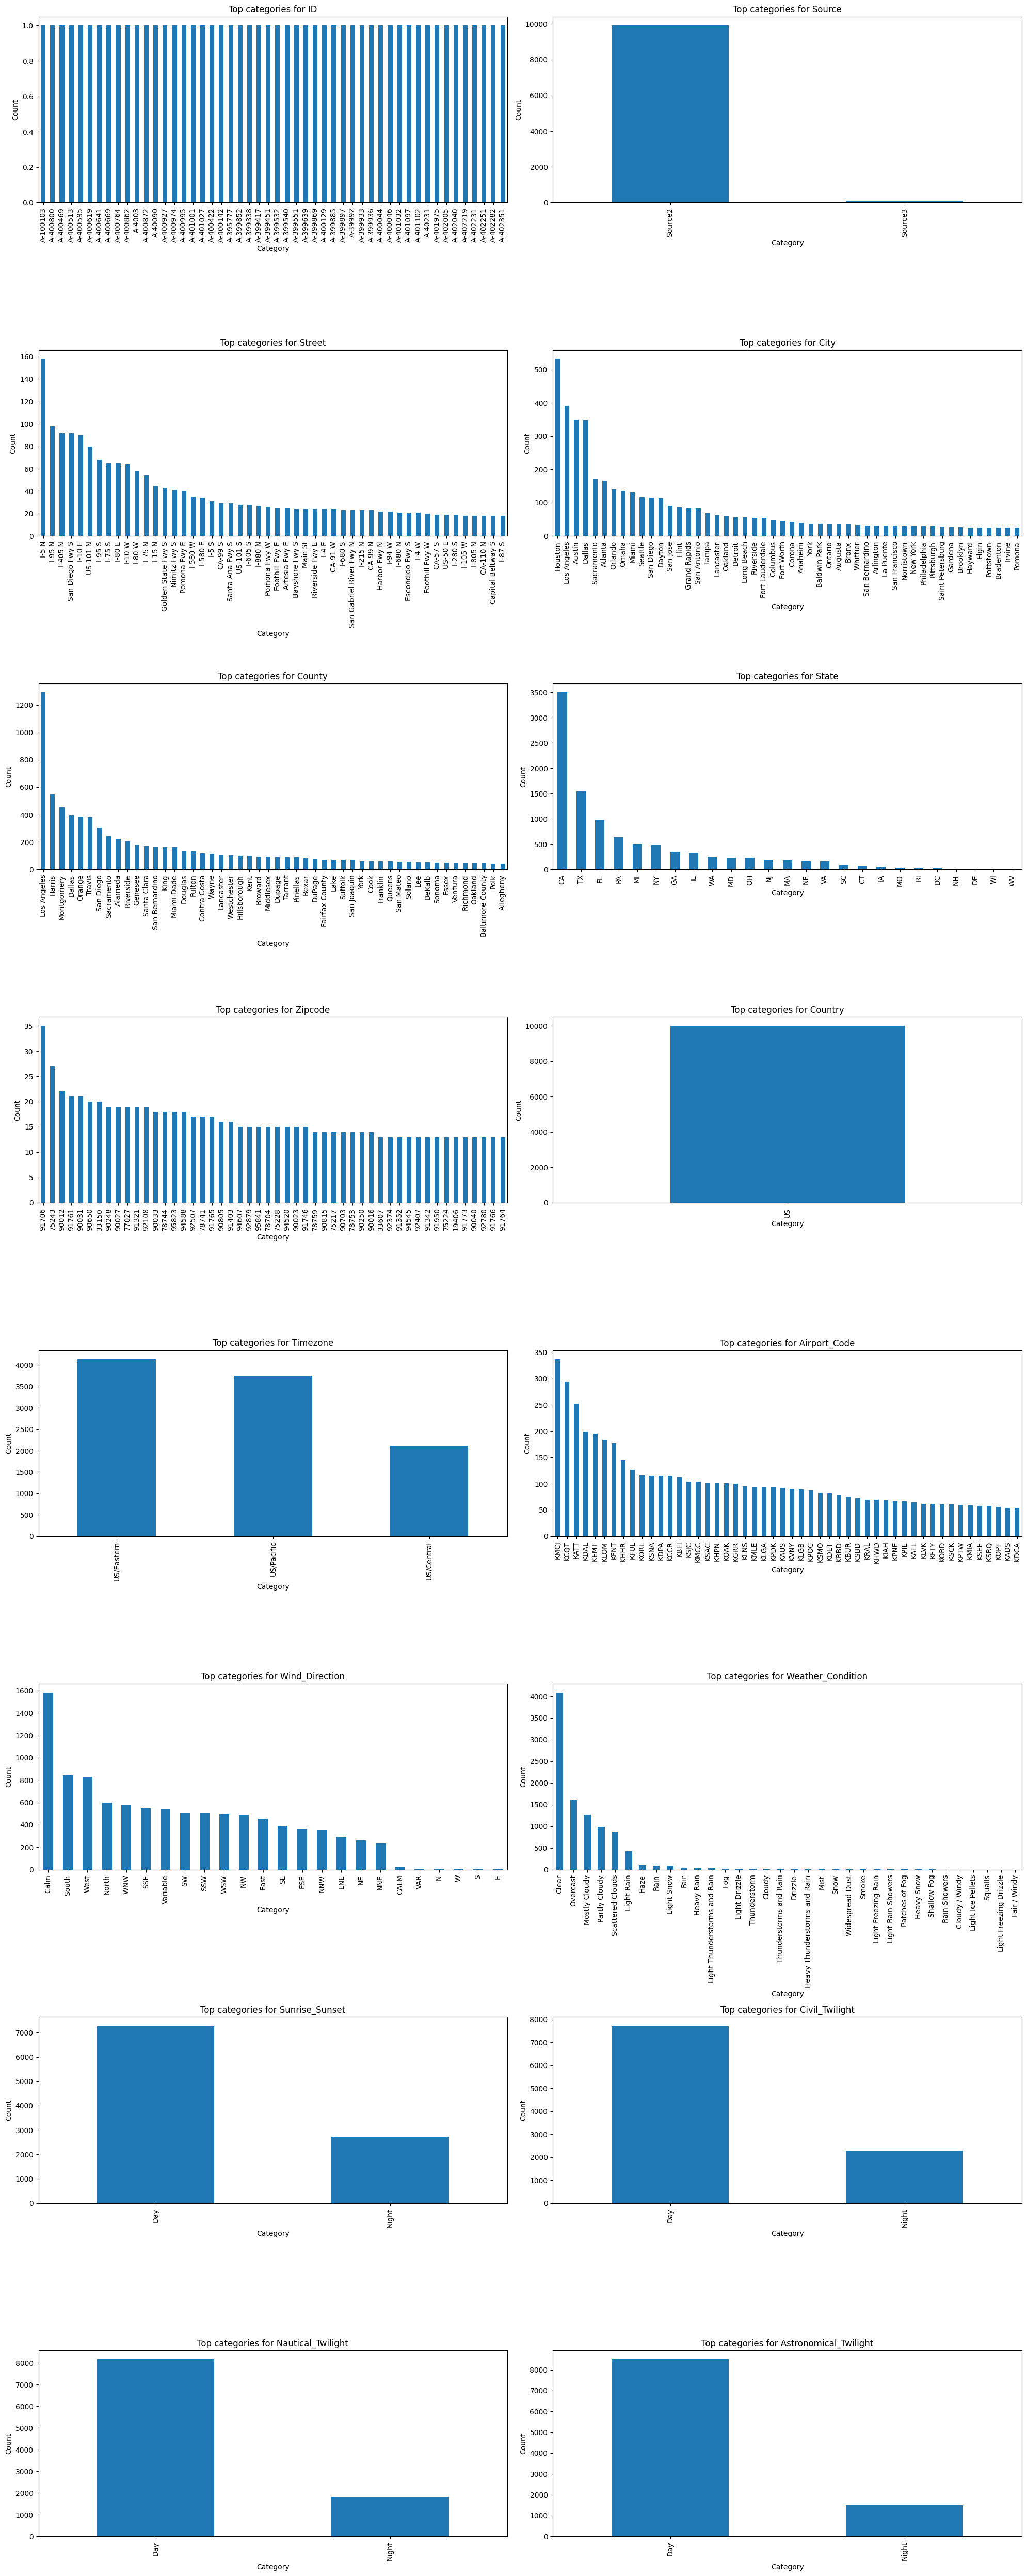

In [71]:
plot_top_categories(dataset_sample, cat_cols)


In [72]:
def plot_years(df, date_feature):
# Create DataFrame
    df_c = df.copy()

    # Extract years from datetime column
    df_c['Date'] = df[date_feature].dt.date

    # Count occurrences of each year
    year_counts = df[date_feature].dt.year.value_counts().sort_index()

    # Plot histogram
    plt.figure(figsize=(10, 6))
    year_counts.plot(kind='bar', color='skyblue')
    plt.title('Histogram of dates')
    plt.xlabel('Day')
    plt.ylabel('Count')

    # Get the positions and labels of the x-ticks
    plt.xticks(ticks=range(len(year_counts.index)), labels=year_counts.index, rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
def plot_time(df, date_feature):
    df_c = df.copy()
    # Extract dates from datetime column
    df_c['Date'] = df[date_feature].dt.date

    # Count occurrences of each date
    date_counts = df_c['Date'].value_counts().sort_index()

    # Plot histogram
    plt.figure(figsize=(10, 6))
    date_counts.plot(kind='bar', color='skyblue')
    plt.title('Histogram of Dates')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

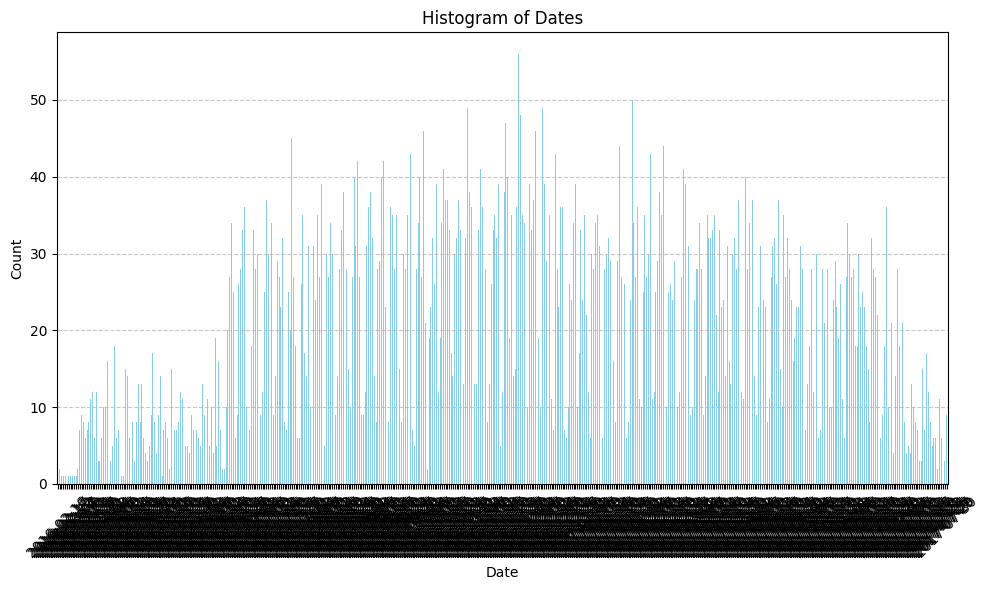

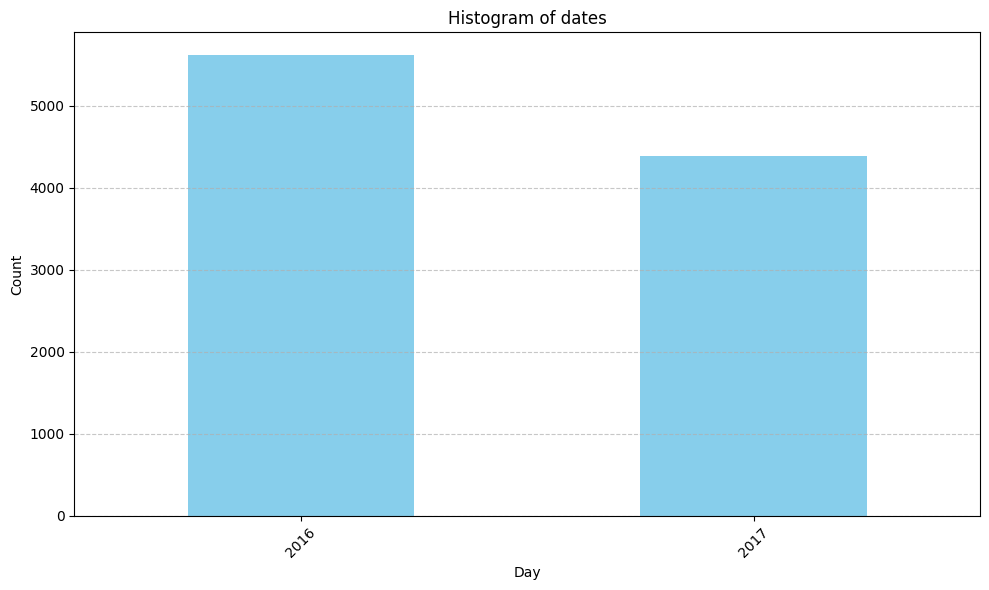

In [73]:
plot_time(dataset_sample, "Start_Time")
plot_years(dataset_sample, "Start_Time")

In [74]:
earliest_date = dataset_sample["Start_Time"].min()
latest_date = dataset_sample['Start_Time'].max()

print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)

Earliest Date: 2016-02-16 06:47:00
Latest Date: 2017-07-30 15:46:49


In [75]:
import seaborn as sns


def plot_scatter_longitude_latitude(df, longitude_feature, latitude_feature):
    plt.figure(figsize=(10, 6))
    plt.scatter(df[longitude_feature], df[latitude_feature], alpha=0.5)
    plt.xlabel(longitude_feature)
    plt.ylabel(latitude_feature)
    plt.title(latitude_feature)
    plt.grid(True)
    plt.show()
    
def plot_scatter_with_category(df, longitude_feature, latitude_feature, category_feature):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=longitude_feature, y=latitude_feature, hue=category_feature, palette='Set1', alpha=0.7)
    plt.xlabel(longitude_feature)
    plt.ylabel(latitude_feature)
    plt.title(category_feature)
    plt.legend(title=category_feature)
    plt.grid(True)
    plt.show()
    
def plot_scatter_with_buckets(df, longitude_feature, latitude_feature, numerical_feature):
    # Discretize the numerical feature into 5 buckets
    df_c = df.copy()
    df_c['bucket'] = pd.cut(df[numerical_feature], bins=5, labels=['Bucket 1', 'Bucket 2', 'Bucket 3', 'Bucket 4', 'Bucket 5'])

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_c, x=longitude_feature, y=latitude_feature, hue='bucket', palette='Set1', alpha=0.7)
    plt.xlabel(longitude_feature)
    plt.ylabel(latitude_feature)
    plt.title(numerical_feature)
    plt.legend(title='Numerical Bucket')
    plt.grid(True)
    plt.show()
    
def plot_scatter_with_separate_plots(df, longitude_feature, latitude_feature, category_feature):
    # Get unique labels in the categorical feature
    unique_labels = df[category_feature].unique()

    # Create separate plots for each label
    for label in unique_labels:
        plt.figure(figsize=(10, 6))
        subset_df = df[df[category_feature] == label]
        sns.scatterplot(data=subset_df, x=longitude_feature, y=latitude_feature, alpha=0.7)
        plt.xlabel(longitude_feature)
        plt.ylabel(latitude_feature)
        plt.title(f'{category_feature}: {label}')
        plt.grid(True)
        plt.show()

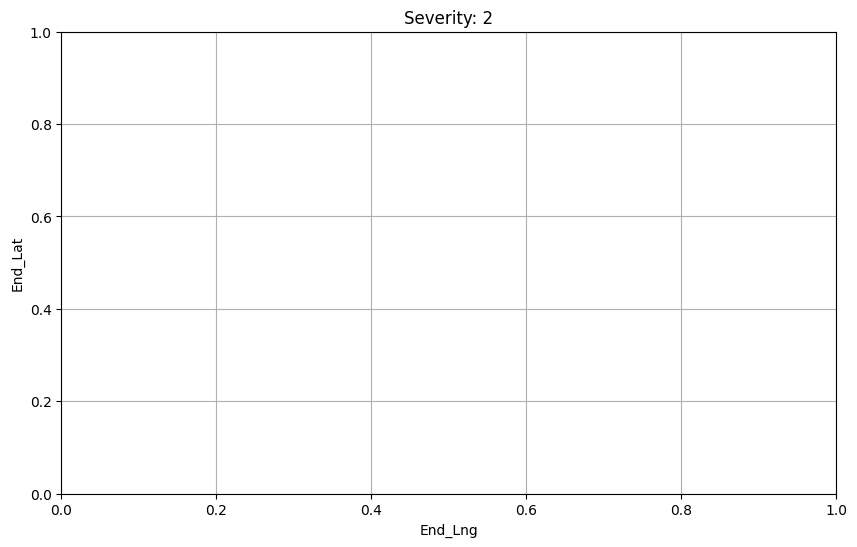

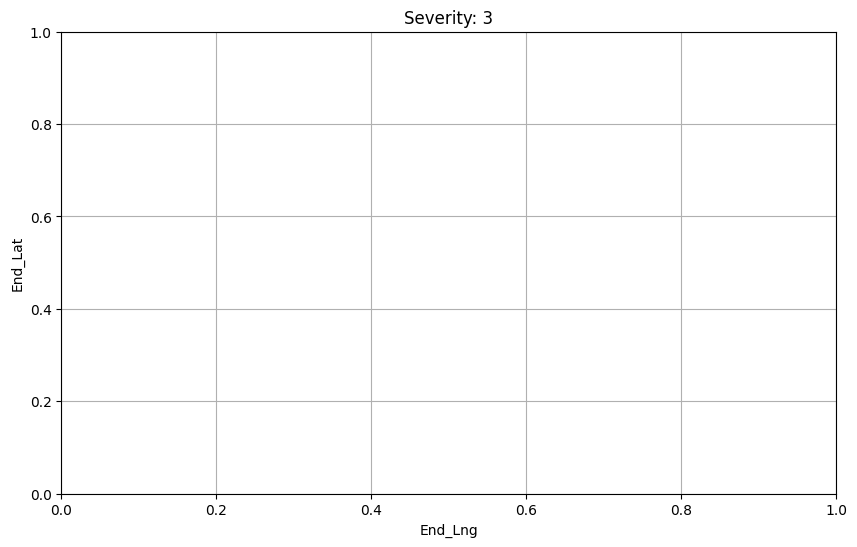

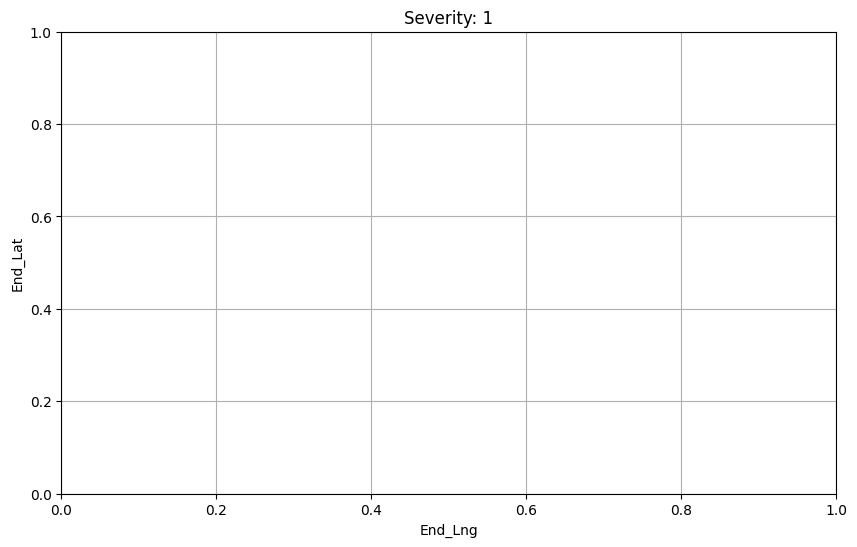

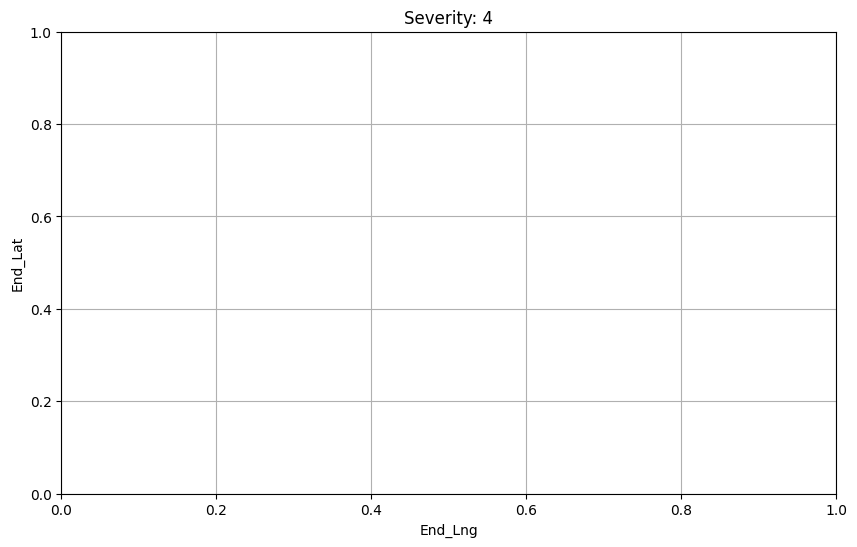

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


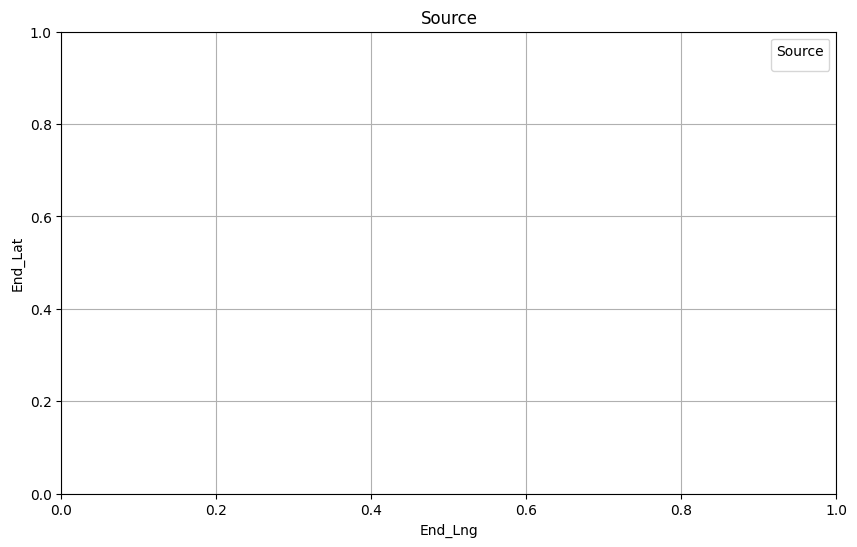

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


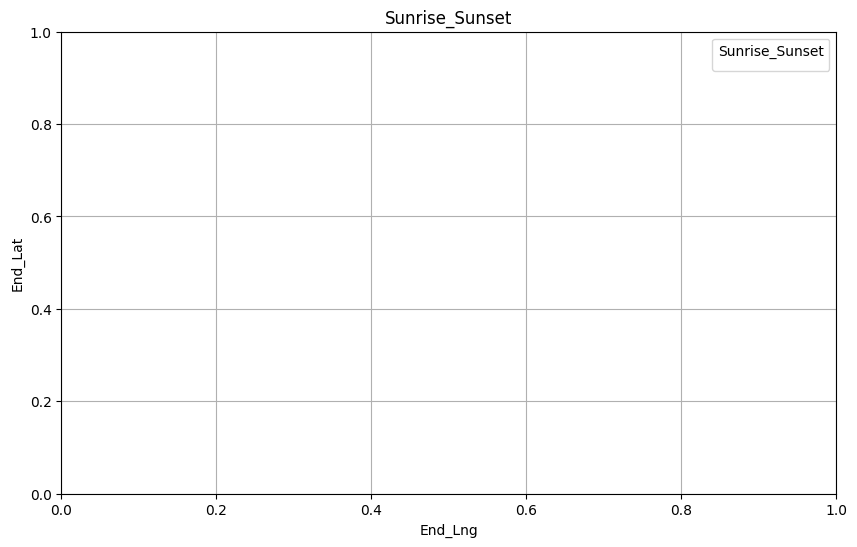

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


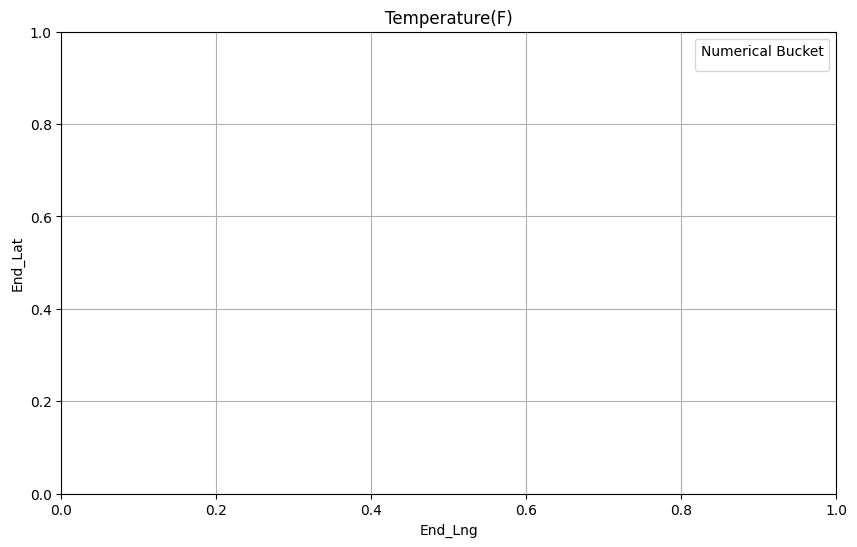

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


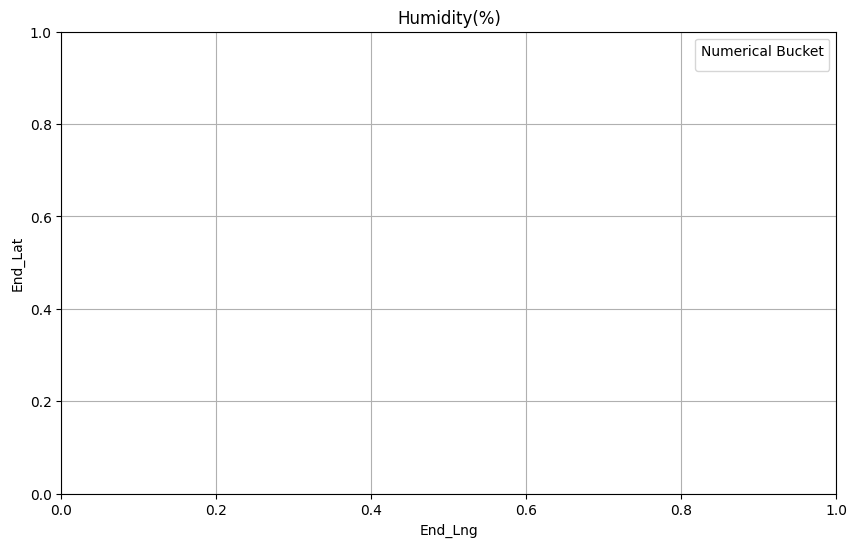

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


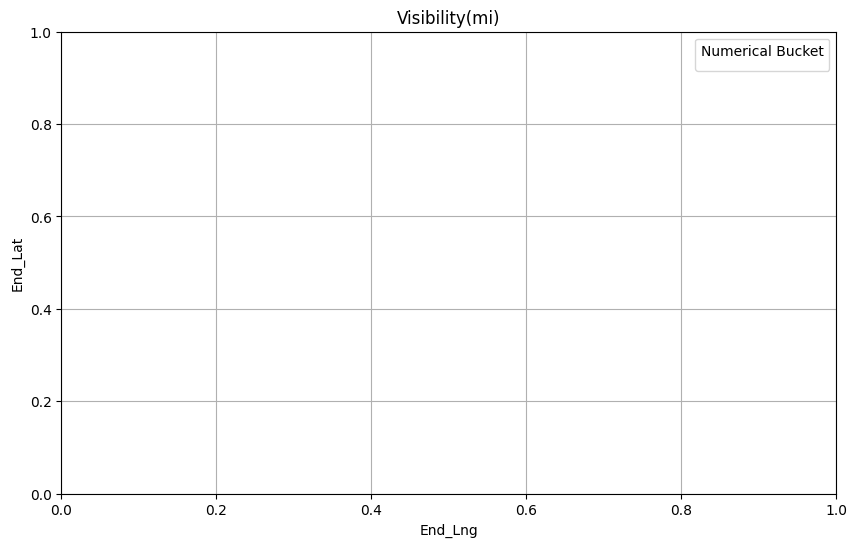

In [76]:
plot_scatter_with_separate_plots(dataset_sample, "End_Lng", "End_Lat", target)
plot_scatter_with_category(dataset_sample, "End_Lng", "End_Lat", "Source")
plot_scatter_with_category(dataset_sample, "End_Lng", "End_Lat", "Sunrise_Sunset")
plot_scatter_with_buckets(dataset_sample, "End_Lng", "End_Lat", "Temperature(F)")
plot_scatter_with_buckets(dataset_sample, "End_Lng", "End_Lat", "Humidity(%)")
plot_scatter_with_buckets(dataset_sample, "End_Lng", "End_Lat", "Visibility(mi)")

In [77]:
dataset_sample.describe()


,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,10000.000000,10000.000000,10000.000000,0.0,0.0,10000.000000,9852.000000,1227.000000,9836.000000,9889.000000,9781.000000,8196.000000,1100.000000
mean,2.374700,35.981906,-97.558635,NaN,NaN,0.044180,64.619153,30.844254,64.868646,30.001132,9.234536,8.931955,0.055800
std,0.486953,5.044410,18.338857,NaN,NaN,0.468445,16.742800,15.649686,21.354352,0.225191,2.266335,10.053054,0.432857
min,1.000000,25.447845,-123.768166,NaN,NaN,0.000000,-0.900000,-14.700000,4.000000,23.000000,0.100000,0.000000,0.000000
25%,2.000000,32.832327,-118.096634,NaN,NaN,0.000000,55.000000,22.200000,49.000000,29.900000,10.000000,5.800000,0.000000
50%,2.000000,34.269011,-95.538967,NaN,NaN,0.010000,66.000000,30.900000,66.000000,30.000000,10.000000,8.100000,0.010000
75%,3.000000,40.138756,-81.436428,NaN,NaN,0.010000,77.000000,38.100000,83.000000,30.110000,10.000000,11.500000,0.032500
max,4.000000,48.152409,-70.619888,NaN,NaN,19.530000,114.800000,101.000000,100.000000,30.830000,80.000000,822.800000,10.000000


In [78]:
total_samples = len(dataset_sample)
rare_category_counts = {}

for feature in dataset_sample[cat_cols].columns:
    category_counts = dataset_sample[feature].value_counts(normalize=True)
    rare_categories = category_counts[category_counts < 0.01]
    total_rare_percentage = rare_categories.sum() * 100
    rare_category_counts[feature] = total_rare_percentage

for feature, percentage in rare_category_counts.items():
    print(f"Feature '{feature}': {percentage:.2f}% of categories are rare (<1%) throughout the dataset.")

Feature 'ID': 100.00% of categories are rare (<1%) throughout the dataset.
Feature 'Source': 0.87% of categories are rare (<1%) throughout the dataset.
Feature 'Street': 98.42% of categories are rare (<1%) throughout the dataset.
Feature 'City': 72.90% of categories are rare (<1%) throughout the dataset.
Feature 'County': 40.20% of categories are rare (<1%) throughout the dataset.
Feature 'State': 3.00% of categories are rare (<1%) throughout the dataset.
Feature 'Zipcode': 100.00% of categories are rare (<1%) throughout the dataset.
Feature 'Country': 0.00% of categories are rare (<1%) throughout the dataset.
Feature 'Timezone': 0.00% of categories are rare (<1%) throughout the dataset.
Feature 'Airport_Code': 69.05% of categories are rare (<1%) throughout the dataset.
Feature 'Wind_Direction': 0.51% of categories are rare (<1%) throughout the dataset.
Feature 'Weather_Condition': 4.46% of categories are rare (<1%) throughout the dataset.
Feature 'Sunrise_Sunset': 0.00% of categories 

In [79]:
def print_top_10_used_categories_in_feature(df, feature):
    category_counts = df[feature].value_counts(normalize=True)
    
    # Filter out categories with frequency more than or equal to 1%
    common_categories = category_counts[category_counts >= 0.01]
    
    # Print the categories and their percentage throughout the dataset
    print(f"Categories in feature '{feature}' that are more than 1%:")
    for category, percentage in common_categories.items():
        print(f"  Category '{category}': {percentage*100:.2f}%")
    print()

In [80]:
print_top_10_used_categories_in_feature(dataset_sample, "City")


Categories in feature 'City' that are more than 1%:
  Category 'Houston': 5.32%
  Category 'Los Angeles': 3.91%
  Category 'Austin': 3.50%
  Category 'Dallas': 3.48%
  Category 'Sacramento': 1.71%
  Category 'Atlanta': 1.66%
  Category 'Orlando': 1.40%
  Category 'Omaha': 1.35%
  Category 'Miami': 1.31%
  Category 'Seattle': 1.17%
  Category 'San Diego': 1.16%
  Category 'Dayton': 1.13%



In [81]:
print_top_10_used_categories_in_feature(dataset_sample, "County")


Categories in feature 'County' that are more than 1%:
  Category 'Los Angeles': 12.93%
  Category 'Harris': 5.47%
  Category 'Montgomery': 4.53%
  Category 'Dallas': 3.95%
  Category 'Orange': 3.85%
  Category 'Travis': 3.81%
  Category 'San Diego': 3.07%
  Category 'Sacramento': 2.42%
  Category 'Alameda': 2.22%
  Category 'Riverside': 2.03%
  Category 'Genesee': 1.80%
  Category 'Santa Clara': 1.72%
  Category 'San Bernardino': 1.67%
  Category 'King': 1.64%
  Category 'Miami-Dade': 1.62%
  Category 'Douglas': 1.36%
  Category 'Fulton': 1.33%
  Category 'Contra Costa': 1.18%
  Category 'Wayne': 1.12%
  Category 'Lancaster': 1.06%
  Category 'Westchester': 1.02%



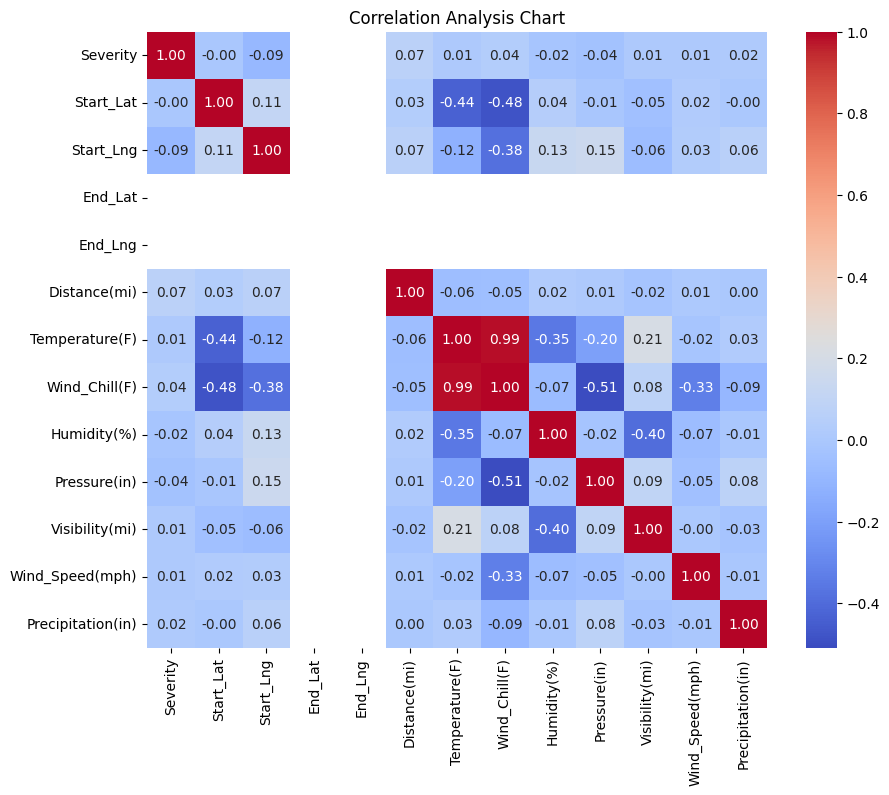

In [82]:
correlation_matrix = dataset_sample[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Analysis Chart')
plt.show()

In [83]:
def make_scatter_plot(df, feature1, feature2):
    plt.figure(figsize=(8, 6))
    x = df[feature1]
    y = df[feature2]
    plt.scatter(x, y, color='blue', alpha=0.7)
    plt.title(f'{feature1} vs {feature2}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.grid(True)
    plt.show()

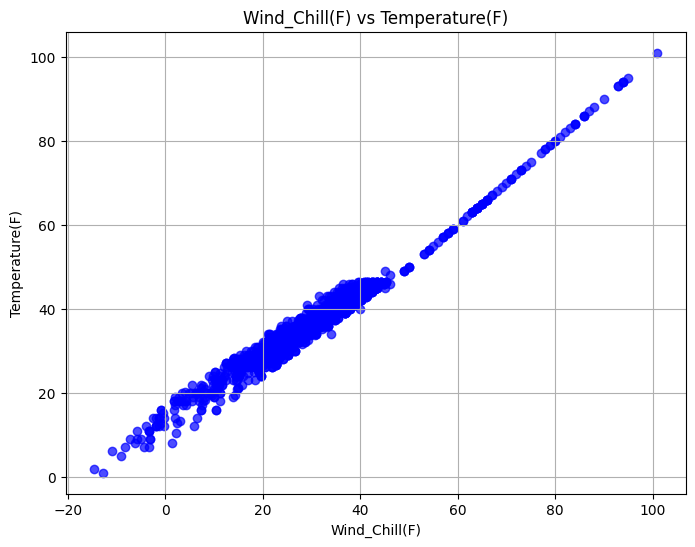

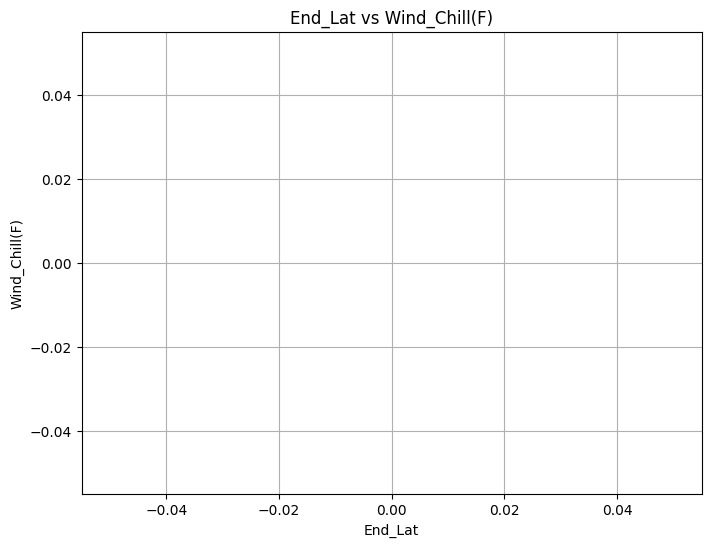

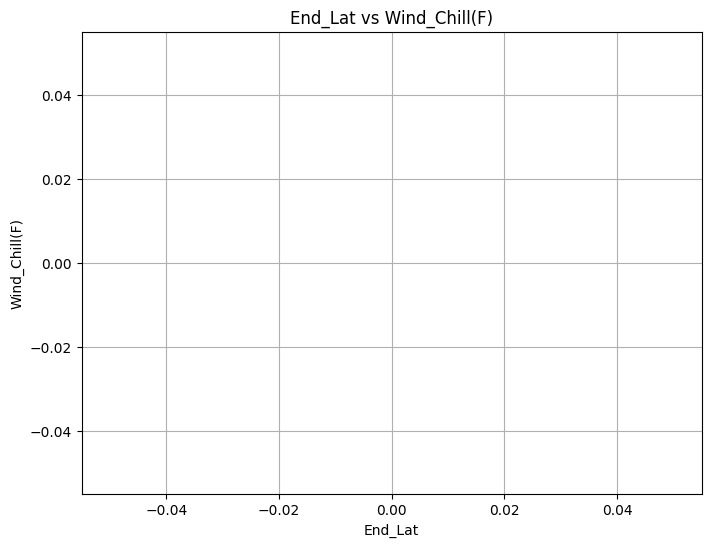

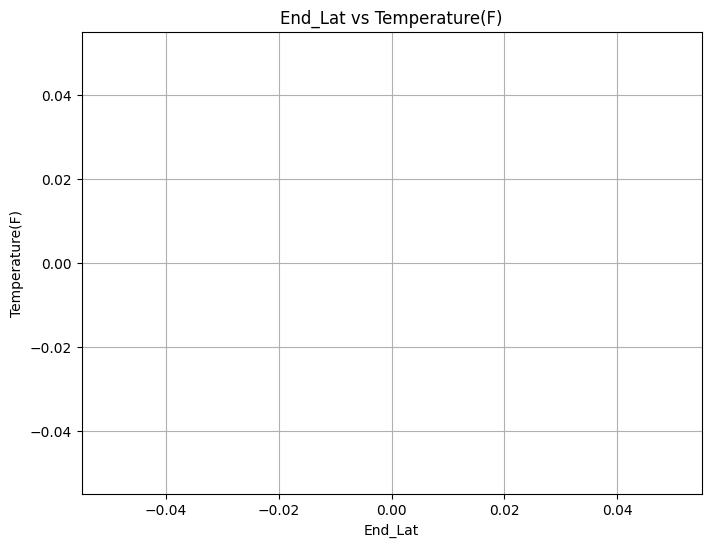

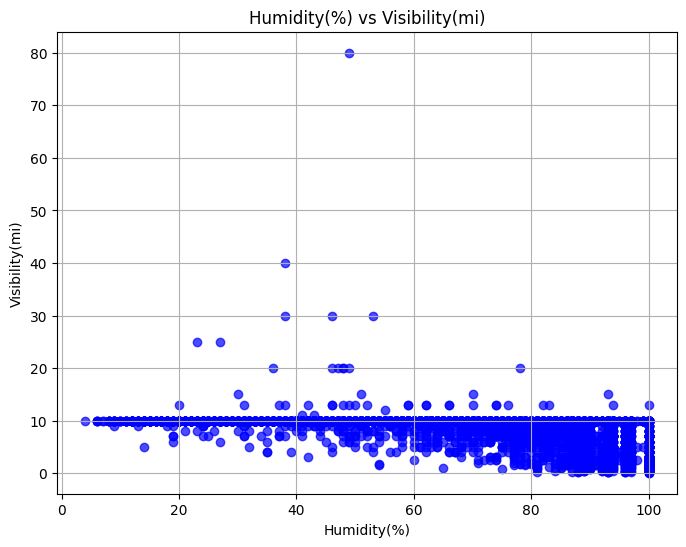

In [84]:
make_scatter_plot(dataset_sample, "Wind_Chill(F)", "Temperature(F)")
make_scatter_plot(dataset_sample, "End_Lat", "Wind_Chill(F)")
make_scatter_plot(dataset_sample, "End_Lat", "Wind_Chill(F)")
make_scatter_plot(dataset_sample, "End_Lat", "Temperature(F)")
make_scatter_plot(dataset_sample, "Humidity(%)", "Visibility(mi)")

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [86]:
class ConvertToNumeric(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.apply(pd.to_numeric, errors='coerce')
        return X


In [87]:
# Datetime

class ConvertToDatetime(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for feature in X.columns:
            X[feature] = pd.to_datetime(X[feature], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        return X
class SplitDatetimeToDateAndTime(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        f_names = []
        for feature in X.columns:
            X[f'{feature}_dt_date'] = X[feature].dt.date
            X[f'{feature}_dt_time'] = X[feature].dt.time
            X[f'{feature}_dt_date'] = pd.to_datetime(X[f'{feature}_dt_date'], format='%Y-%m-%d', errors='coerce')
            X[f'{feature}_dt_time'] = pd.to_datetime(X[f'{feature}_dt_time'], format='%H:%M:%S', errors='coerce')
            f_names.append(feature)
            
        X = X.drop(f_names, axis=1)        
        return X
class EncodeTimeIntoHours():
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):        
        for feature in X.columns:
            if feature.find('_dt_time') != -1:
                X[feature] = X[feature].dt.hour
        return X
    
class EncodeDate():
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):        
        for feature in X.columns:
            if feature.find('_dt_date') != -1:
                earliest_date = X[feature].min()
                X[feature] = (X[feature] - earliest_date).dt.days
        return X
    


In [88]:
# Category

class ConvertToObject():
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.astype(object)
        return X
    
        

class MergeWeatherConditions():
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        categories_to_merge_within = ['Fair', 'Cloudy', 'Rain', 'Snow', 'Windy', 'Thunder', 'Smoke']
        words_to_merge_into = [
            ['Clear'],['Mist', 'Clouds', 'Cloud', 'Overcast'], 
            ['Drizzle', 'Showers', 'Hail', 'Precipitation', 'Pellets', 'Squalls'], ['Wintry', 'Sleet'], 
            ['Tornado', 'Fog', 'Haze'], ['T-Storm'], ['Dust', 'Sand']
        ]

        for i in range(7):
            mask = X["Weather_Condition"].str.contains(categories_to_merge_within[i], case=False, na=False)
            X.loc[mask] = categories_to_merge_within[i]
            
            for category in words_to_merge_into[i]:                
                mask = X["Weather_Condition"].str.contains(category, case=False, na=False)
                X.loc[mask] = categories_to_merge_within[i]
            
        return X
class ConvertToCategory():
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for i in range(X.shape[1]):
            X[:, i] = pd.Series(X[:, i]).astype('category')
        return X
class CombineRareAndCommonCategories(): 
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            for feature in X.columns:
                category_counts = X[feature].value_counts(normalize=True)

                # Step 1: Identify categories that occur less than 1%
                rare_categories = category_counts[category_counts < 0.01].index.tolist()

                # Step 2: Replace rare categories with a new category label
                X[feature] = X[feature].apply(lambda x: 'hub_of_few_accidents' if x in rare_categories else x)

 # Step 3: Identify categories that occur more than or equal to 1%
                common_categories = category_counts[category_counts >= 0.01].index.tolist()

                # Step 4: Replace common categories with a new category label
                X[feature] = X[feature].apply(lambda x: 'hub_of_many_accidents' if x in common_categories else x)

            return X
        elif isinstance(X, np.ndarray):
            # Convert numpy array to DataFrame
            X_df = pd.DataFrame(X)

            for feature in X_df.columns:
                category_counts = X_df[feature].value_counts(normalize=True)

                # Step 1: Identify categories that occur less than 1%
                rare_categories = category_counts[category_counts < 0.01].index.tolist()
                X_df[feature] = X_df[feature].apply(lambda x: 'hub_of_few_accidents' if x in rare_categories else x)

                # Step 3: Identify categories that occur more than or equal to 1%
                common_categories = category_counts[category_counts >= 0.01].index.tolist()

                # Step 4: Replace common categories with a new category label
                X_df[feature] = X_df[feature].apply(lambda x: 'hub_of_many_accidents' if x in common_categories else x)

            return X_df
        else:
            raise ValueError("Unsupported input type. Only pandas DataFrame and numpy array are supported.")



class CombineRareCategories():
    def __init__(self, percentage):
        self.percentage = percentage

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            for feature in X.columns:
                category_counts = X[feature].value_counts(normalize=True)

                # Step 2: Identify categories that occur less than 1%
                rare_categories = category_counts[category_counts < self.percentage].index.tolist()

                # Step 3: Replace rare categories with a new category label or combine them into a single category
                new_category_label = 'other'
                X[feature] = X[feature].apply(lambda x: new_category_label if x in rare_categories else x)

            return X
        elif isinstance(X, np.ndarray):

            # Assuming X is a numpy array of shape (n_samples, n_features)
            # Convert it to a DataFrame for processing
            X_df = pd.DataFrame(X)
            for feature in X_df.columns:
                category_counts = X_df[feature].value_counts(normalize=True)

                # Step 2: Identify categories that occur less than 1%
                rare_categories = category_counts[category_counts < self.percentage].index.tolist()

                # Step 3: Replace rare categories with a new category label or combine them into a single category
                new_category_label = 'other'
                X_df[feature] = X_df[feature].apply(lambda x: new_category_label if x in rare_categories else x)

            return X_df
        else:
            raise ValueError("Unsupported input type. Only pandas DataFrame and numpy array are supported.")


In [89]:
class TurnNullIntoFalse():
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for feature in X.columns:
            X[feature] = X[feature].fillna(False)

        return X

In [90]:
class TextVectorizer():
    def __init__(self, feature):
        self.feature = feature
        self.vectorizer = TfidfVectorizer()
    
    def fit(self, X, y=None):
        self.vectorizer.fit(X[self.feature].astype(str))
        return self
    
    def transform(self, X):
        transformed_text = self.vectorizer.transform(X[self.feature].astype(str))
        transformed_text_df = pd.DataFrame(transformed_text.toarray(), columns=self.vectorizer.get_feature_names_out())
        X_transformed = pd.concat([X.drop(columns=[self.feature]), transformed_text_df], axis=1)
        return X_transformed

In [91]:
features_to_remove = ['Turning_Loop', 'ID', 'Country', 'End_Lng', 'End_Lat', 'Wind_Chill(F)', 'Street', 'Description', 'Zipcode', 'Airport_Code', 'Timezone']

num_cols = [f for f in num_cols if f not in features_to_remove]
cat_cols = [f for f in cat_cols if f not in features_to_remove]
datetime_cols = [f for f in datetime_cols if f not in features_to_remove]
string_cols = [f for f in string_cols if f not in features_to_remove]
bool_cols = [f for f in bool_cols if f not in features_to_remove]

In [92]:
features_with_many_rare_categories = ['City', 'County']


In [93]:
numeric_pipeline = Pipeline(steps=[
    ('convert_to_numeric', ConvertToNumeric()),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('scaler', StandardScaler())
])

bool_pipeline = Pipeline(steps=[
    ('turn_null_into_false', TurnNullIntoFalse())
])

datetime_pipeline = Pipeline(steps=[
    ('convert_to_datetime', ConvertToDatetime()),
    ('split_datetime_into_date_and_time', SplitDatetimeToDateAndTime()),
    ('encode_time_into_hours', EncodeTimeIntoHours()),
    ('encode_date', EncodeDate()),
    ('convert_null_to_0', SimpleImputer(strategy='constant', fill_value=0))
])

category_pipeline = Pipeline(steps=[
    ('convert_to_object', ConvertToObject()),
    ('merge_null_into_category', SimpleImputer(strategy='constant', fill_value='null_cat')),
    ('combine_rare_categories', CombineRareCategories(0.10)),
    ('encode_categories', OrdinalEncoder()),  
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore')),
])

rare_category_pipeline = Pipeline(steps=[
    ('convert_to_object', ConvertToObject()),
    ('merge_null_into_category', SimpleImputer(strategy='constant', fill_value='null_cat')),
    ('combine_rare_and_common_categories', CombineRareAndCommonCategories()),
    ('encode_categories', OrdinalEncoder()),  
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore'))
])

weather_pipeline = Pipeline(steps=[
    ('convert_to_object', ConvertToObject()),
    ('merge_weather_conditions', MergeWeatherConditions()),
    ('merge_null_into_category', SimpleImputer(strategy='constant', fill_value='null_cat')),
    ('combine_rare_categories', CombineRareCategories(0.10)),
    ('encode_categories', OrdinalEncoder()),
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore'))  
])

text_transfromer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())
])




column_transformer = ColumnTransformer(transformers=[
    ('remove_features', 'drop', features_to_remove),
    ('merge_weather_conditions', weather_pipeline, ["Weather_Condition"]),
    ('category_pipeline', category_pipeline, [col for col in cat_cols if (col != "Weather_Condition") and (col not in features_with_many_rare_categories)] ),
    ('rare_category_pipeline', rare_category_pipeline, features_with_many_rare_categories),
    ('numeric_pipeline', numeric_pipeline, [f for f in num_cols if f != target]),
    ('boolean_pipeline', bool_pipeline, bool_cols),
    ('datetime_pipeline', datetime_pipeline, datetime_cols)
    #('text_pipeline', text_transfromer, ['Description'])  
])


In [94]:
column_transformer


ColumnTransformer(transformers=[('remove_features', 'drop',
                                 ['Turning_Loop', 'ID', 'Country', 'End_Lng',
                                  'End_Lat', 'Wind_Chill(F)', 'Street',
                                  'Description', 'Zipcode', 'Airport_Code',
                                  'Timezone']),
                                ('merge_weather_conditions',
                                 Pipeline(steps=[('convert_to_object',
                                                  <__main__.ConvertToObject object at 0x0000022B90F6CBE0>),
                                                 ('merge_weather_conditions',
                                                  <__main__.MergeWe...
                                                  ConvertToDatetime()),
                                                 ('split_datetime_into_date_and_time',
                                                  SplitDatetimeToDateAndTime()),
                                                 ('encode_time_into_hours',
                                                  <__main__.EncodeTimeIntoHours object at 0x0000022B90F6F190>),
                                                 ('encode_date',
                                                  <__main__.EncodeDate object at 0x0000022B90F6EBC0>),
                                                 ('convert_null_to_0',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'))]),
                                 ['Start_Time', 'End_Time',
                                  'Weather_Timestamp'])])

In [95]:
datetime_df = datetime_pipeline.fit_transform(dataset_sample[datetime_cols].copy())
pd.DataFrame(datetime_df).head()


,0,1,2,3,4,5
0,329.0,11.0,329.0,11.0,329.0,10.0
1,250.0,17.0,250.0,18.0,250.0,17.0
2,477.0,10.0,477.0,11.0,477.0,10.0
3,517.0,7.0,517.0,8.0,517.0,7.0
4,462.0,7.0,462.0,7.0,462.0,6.0


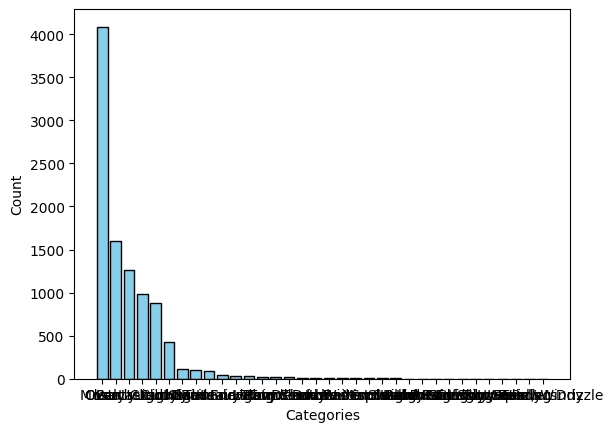

In [96]:
category_counts = dataset_sample['Weather_Condition'].value_counts()
plt.bar(category_counts.index, category_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

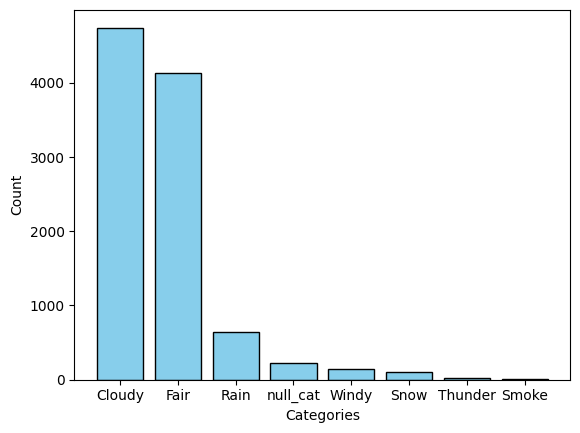

In [97]:
merge_pipeline = Pipeline(steps=[
    ('convert_to_object', ConvertToObject()),
    ('merge_weather_conditions', MergeWeatherConditions()),
    ('merge_null_into_category', SimpleImputer(strategy='constant', fill_value='null_cat')),

])

# applying the pipeline
weather_df = merge_pipeline.fit_transform(dataset_sample[["Weather_Condition"]].copy())
weather_df = pd.DataFrame(weather_df)

# making the plot
category_counts = weather_df[0].value_counts()
plt.bar(category_counts.index, category_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

In [98]:
merge_rare_cat_pipeline = Pipeline(steps=[
    ('convert_to_object', ConvertToObject()),
    ('merge_null_into_category', SimpleImputer(strategy='constant', fill_value='null_cat')),
    ('combine_rare_categories', CombineRareCategories(0.5))
])

print(dataset_sample[[col for col in cat_cols if (col != "Weather_Condition") and (col not in features_with_many_rare_categories)]].info())

merged_rare_c_df = merge_rare_cat_pipeline.fit_transform(dataset_sample[[col for col in cat_cols if (col != "Weather_Condition") and (col not in features_with_many_rare_categories)]].copy())
merged_rare_c_df = pd.DataFrame(merged_rare_c_df)

for c_feature in merged_rare_c_df.columns:
    other_percentage = (merged_rare_c_df[c_feature].value_counts(normalize=True).get('other', 0)) * 100
    print(f'{c_feature} : {other_percentage}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 269322 to 472645
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Source                 10000 non-null  category
 1   State                  10000 non-null  category
 2   Wind_Direction         9927 non-null   category
 3   Sunrise_Sunset         10000 non-null  category
 4   Civil_Twilight         10000 non-null  category
 5   Nautical_Twilight      10000 non-null  category
 6   Astronomical_Twilight  10000 non-null  category
dtypes: category(7)
memory usage: 148.6 KB
None
0 : 0.8699999999999999
1 : 100.0
2 : 100.0
3 : 27.27
4 : 22.900000000000002
5 : 18.4
6 : 15.010000000000002


In [99]:
combine_common_and_rare_cat_pipeline = Pipeline(steps=[
    ('convert_to_object', ConvertToObject()),
    ('merge_null_into_category', SimpleImputer(strategy='constant', fill_value='null_cat')),
    ('combine_rare_and_common_categories', CombineRareAndCommonCategories())
])

print(dataset_sample[features_with_many_rare_categories].info())

merged_rare_common_c_df = combine_common_and_rare_cat_pipeline.fit_transform(dataset_sample[features_with_many_rare_categories].copy())
merged_rare_common_c_df = pd.DataFrame(merged_rare_common_c_df)

for c_feature in merged_rare_common_c_df.columns:
    many_percentage = (merged_rare_common_c_df[c_feature].value_counts(normalize=True).get('hub_of_many_accidents', 0)) * 100
    few_percentage = (merged_rare_common_c_df[c_feature].value_counts(normalize=True).get('hub_of_few_accidents', 0)) * 100

    print(f'{c_feature} : {many_percentage} - hub_of_many_accidents')
    print(f'{c_feature} : {few_percentage} - hub_of_few_accidents')
    

merged_rare_common_c_df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 269322 to 472645
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   City    10000 non-null  category
 1   County  10000 non-null  category
dtypes: category(2)
memory usage: 204.6 KB
None
0 : 27.1 - hub_of_many_accidents
0 : 72.89999999999999 - hub_of_few_accidents
1 : 59.8 - hub_of_many_accidents
1 : 40.2 - hub_of_few_accidents


,0,1
0,hub_of_many_accidents,hub_of_many_accidents
1,hub_of_few_accidents,hub_of_many_accidents
2,hub_of_few_accidents,hub_of_few_accidents
3,hub_of_few_accidents,hub_of_few_accidents
4,hub_of_few_accidents,hub_of_few_accidents


In [100]:
y = dataset_sample[target]
X = dataset_sample.drop(columns=target, axis=1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15 / 0.9, random_state=42)


In [101]:
# Random forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'classifier__n_estimators': [100],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 3, 5]
}

pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('classifier', RandomForestClassifier())
])


grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

rf_best_model = grid_search.best_estimator_
rf_y_pred = rf_best_model.predict(X_test)

In [102]:
# NearestNeighbours
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'classifier__n_neighbors': [5, 10],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'classifier__leaf_size': [30, 20, 40]
}

pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('classifier', KNeighborsClassifier())
])


grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

kn_best_model = grid_search.best_estimator_
kn_y_pred = kn_best_model.predict(X_test)

In [103]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
    'classifier__n_estimators': [50, 40, 70],
    'classifier__learning_rate': [1.0, 0.1, 0.01],
    'classifier__algorithm': ['SAMME', 'SAMME.R'],
}

pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('classifier', AdaBoostClassifier())
])


grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

ada_best_model = grid_search.best_estimator_
ada_y_pred = ada_best_model.predict(X_test)

In [104]:
# VotingClassifier
from sklearn.ensemble import VotingClassifier


classifier = VotingClassifier(
    estimators=[('rf', rf_best_model), ('kn', kn_best_model), ('ada', ada_best_model)],
    voting='soft'
)

classifier.fit(X_train, y_train)
voting_y_pred = classifier.predict(X_test)

In [105]:
# Best parameters
models = [rf_best_model, kn_best_model, ada_best_model]

for model, name in zip(models, ["RF", "KN", "ADA"]):
    print(name)
    model_params = model.named_steps['classifier'].get_params()
    for param, value in model_params.items():
        print(f"{param}: {value}")
    print("------------")

RF
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False
------------
KN
algorithm: auto
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: None
n_neighbors: 5
p: 2
weights: uniform
------------
ADA
algorithm: SAMME
estimator: None
learning_rate: 1.0
n_estimators: 50
random_state: None
------------


In [109]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


scores = {}

preds = [rf_y_pred, kn_y_pred, ada_y_pred, voting_y_pred]

for pred, name in zip(preds, ["RF", "KN", "ADA", "Voting"]):
    accuracy = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average='weighted')  # 'weighted' for multi-class classification
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    scores[name] = [accuracy, f1, precision, recall]

for score in scores:
    print(f"{score}: accuracy: {scores[score][0]}, f1: {scores[score][1]}, precision: {scores[score][2]}, recall: {scores[score][3]}")

    

RF: accuracy: 0.728, f1: 0.7220361535406375, precision: 0.7207296517449164, recall: 0.728
KN: accuracy: 0.551, f1: 0.5327786314906734, precision: 0.5251974206349206, recall: 0.5509999999999999
ADA: accuracy: 0.635, f1: 0.5832547555152646, precision: 0.6118940685652096, recall: 0.635
Voting: accuracy: 0.645, f1: 0.6223291762642502, precision: 0.6263591334307334, recall: 0.645
